In [1]:
%pip install --upgrade pip
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.
Ignoring tensorflow: markers 'sys_platform == "linux"' don't match your environment
Ignoring tensorflow: markers 'sys_platform == "windows"' don't match your environment
Ignoring tensorflow-macos: markers 'sys_platform == "darwin"' don't match your environment
Note: you may need to restart the kernel to use updated packages.


Started a new Leak_Nonleak jupyter notebook to seperate the optical flow model for now

- Goal: To see accuracy and loss of temporal model without stacking
- Future Goal: Add this to original jupyter notebook to have everything in one

In [2]:
import os, sys, shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
blur_kernel_size = 5
threshold_block_size = 9
threshold_constant = 2

def preprocessing(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #blur = cv2.GaussianBlur(gray, (blur_kernel_size, blur_kernel_size), 0)
    #threshold_frame = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, threshold_block_size, threshold_constant)
    return gray

In [4]:
#changed the helper function as we are calculating the optical flow between frames
def extractImages(pathIn, pathOut, leakRange, nonleakRange):

  '''
  Input:
    String: pathIn should be the path of the video 
    String: pathOut should be the path of the folder where the name of the folder is the name of the video
    Tuple: range of leak frames from video
    Tuple: range of nonleak frames from video

  Output:
    creates two subfolders in pathOut called Leaks and Nonleaks
      Leaks folder contains the frames where there are leaks
      Nonleaks folder contains the frames where there are noleaks
  '''

  leakPath = os.path.join(pathOut, "Leak")
  nonleakPath = os.path.join(pathOut, "Nonleaks")
  
  os.makedirs(leakPath, exist_ok=True)
  os.makedirs(nonleakPath, exist_ok=True)

  def helper(pathIn, pathOut, range, isleak):
    '''
    Might need to clean this up, but this was extracted from the original extractImages from the previous implementation
    
    '''
    count = range[0]
    start = 0
    vidcap = cv2.VideoCapture(pathIn)
    success, prev_frame = vidcap.read()

    # original_frame = prev_frame
    # prev_frame = prev_frame - original_frame
    prev_frame = preprocessing(prev_frame)

    success = True
    X_design = []



    if vidcap.isOpened():
      while success and count < range[1]:
          vidcap.set(cv2.CAP_PROP_POS_MSEC, (start*1000))    # added this line 
          success, next_frame = vidcap.read()

          # next_frame = next_frame - original_frame
          next_frame = preprocessing(next_frame)
          
          if success:
            #print ('Read a new frame: ', count, " ,isleak: ", isleak)
            label = 0

            flow = cv2.calcOpticalFlowFarneback(prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            horz = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
            vert = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)

            horz = horz.astype('uint8')
            vert = vert.astype('uint8')

            # horz = horz.reshape(*(horz.shape), 1)
            # vert = vert.reshape(*(vert.shape), 1)
            #stacking the matrix to get w * l * 2
            stacked_matrix = np.stack((horz, vert), axis=2)
            # print("horz dim", horz.shape )
            # print("vert dim", vert.shape )
            # print("stacked dim", stacked_matrix.shape)
            if isleak:
              cv2.imwrite(os.path.join(pathOut, "leak.frame%d.horz.jpg" % count), horz)
              cv2.imwrite(os.path.join(pathOut, "leak.frame%d.vert.jpg" % count), vert)
              label = 1
            else:
              cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.horz.jpg" % count), horz)
              cv2.imwrite(os.path.join(pathOut, "nonleak.frame%d.vert.jpg" % count), vert)
            # X_design.append(np.array(horz))
            # X_design.append(np.array(vert))
            X_design.append(stacked_matrix)
            prev_frame = next_frame.copy()
            count += 1
            start += 1
          else:
            print("Error stop at frame:", count, "isleak: ", isleak)
            break
      vidcap.release()
    cv2.destroyAllWindows()
    return np.stack(X_design, axis=0) 
  # call helper for both leak and nonleak
  X_leak = helper(pathIn, leakPath, leakRange, True)
  y_leak = np.ones(X_leak.shape[0])
  X_nonleak = helper(pathIn, nonleakPath, nonleakRange, False)
  y_nonleak = np.zeros(X_nonleak.shape[0])
  # print("X_leak dim", X_leak.shape)
  # print("X_nonleak dim", X_nonleak.shape)
  X = np.concatenate((X_leak, X_nonleak), axis=0)
  y = np.concatenate((y_leak, y_nonleak), axis=0)
  
  return X, y

In [5]:
#MIGHT NEED TO CHANGE SO I DONT REWRITE PREVIOUS STUFF

# get generic path to directory
dir_path = os.path.dirname(os.path.realpath("__file__"))

# get all raw video data directories
data_dir = os.path.join(dir_path, 'data')

train_data_dir = os.path.join(data_dir, 'train')
test_data_dir = os.path.join(data_dir, 'test')

frame_data_dir = os.path.join(dir_path, 'frame_data_optical_flow')
frame_train_data_dir = os.path.join(frame_data_dir, 'train')
frame_test_data_dir = os.path.join(frame_data_dir, 'test')

In [6]:
raw_data = np.loadtxt(os.path.join(dir_path, 'leak_range.csv'), skiprows=1, delimiter=',', dtype=int)

nonleak_range = dict(zip(raw_data[:, 0], raw_data[:, 1:3]))

In [7]:
def read_frames_from_dir(dir_path, output_path, image_dim, max_vids=None):
    cur_count = 1
    X_train, y_train = np.array([], dtype=np.int64).reshape(0, image_dim[0], image_dim[1], 2), []
    for file in os.listdir(dir_path):
        if max_vids and cur_count > max_vids:
            break
        vid_path = os.path.join(dir_path, file)
        vid_id = int(os.path.basename(vid_path)[4:8])

        nonleak_start = 1
        nonleak_end = nonleak_range[vid_id][0]
        leak_start = nonleak_end + 1
        leak_end = nonleak_range[vid_id][1]

        X_vid, y_vid = extractImages(vid_path, output_path, (leak_start, leak_end), (nonleak_start, nonleak_end))
        # print("X_vid dim", X_vid.shape)
        X_train = np.concatenate((X_train, X_vid), axis=0)
        y_train.append(y_vid)
        print('Done with', cur_count, "videos")
        cur_count += 1
    y_train = np.concatenate(y_train, axis=0) # improve time complexity
    return X_train, y_train

In [8]:
image_dim = (240, 320)
vid_count = 10 #max 18
test_count = 4 #max 13

X_train, y_train = read_frames_from_dir(train_data_dir, frame_train_data_dir, image_dim, vid_count)
print("Done with Training Data")
X_test, y_test = read_frames_from_dir(test_data_dir, frame_test_data_dir, image_dim, test_count)
print("Done with Testing Data")

X_train.shape, y_train.shape, X_test.shape, y_test.shape

Done with  1 videos
Done with  2 videos
Done with  3 videos
Done with  4 videos
Done with  5 videos
Done with  6 videos
Done with  7 videos
Done with  8 videos
Done with  9 videos
Done with  10 videos
Done with Training Data
Done with  1 videos
Done with  2 videos
Done with  3 videos
Done with  4 videos
Done with Testing Data


((15091, 240, 320, 2), (15091,), (5939, 240, 320, 2), (5939,))

In [9]:
#only need to change the input_shape as it will be 240 * 320 * 2
from keras import layers 
from keras import models 

model = models.Sequential() 

# Conv Pool 1
model.add(layers.Conv2D(4, (3, 3), input_shape=(240, 320, 2)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Conv Pool 2
model.add(layers.Conv2D(8, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(2400, activation='relu')) 
# model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid')) 

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 238, 318, 4)       76        
                                                                 
 batch_normalization (BatchN  (None, 238, 318, 4)      16        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 238, 318, 4)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 159, 4)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 159, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 157, 8)       2

In [10]:
from keras import optimizers 
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=1e-4), metrics=[get_f1])

In [11]:
val_split = 0.2
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, test_size=val_split, stratify=y_train)

X = np.concatenate((X_t, X_v))
y = np.concatenate((y_t, y_v))

In [12]:
nonleaks = len(y) - sum(y)
leaks = sum(y)
total = len(y)

weight_nonleak = (1 / nonleaks) * (total / 2.0)
weight_leak = (1 / leaks) * (total / 2.0)

class_weight = {0: weight_nonleak, 1: weight_leak}
class_weight

{0: 3.9197402597402595, 1: 0.5731049673401185}

In [13]:
#edited out sample weights need to discuss what we can do with that
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

# for now, dont do augmentation
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
    validation_split=val_split,
#     horizontal_flip=True,
#     shear_range=0.2,
#     zoom_range=0.05,
)

train_datagen.fit(X)

train_flow = train_datagen.flow(
    X, y, 
    #sample_weight = X_train_weights,
    # target_size=(150, 150), 
    batch_size=batch_size,
    # class_mode='binary',
    subset='training'
)

val_flow = train_datagen.flow(
    X, y, 
    # target_size=(150, 150), 
    batch_size=batch_size,
    # class_mode='binary',
    subset='validation'
)

c:\Users\bestlab\Squishy-Methane-Analysis\lib\site-packages\keras\preprocessing\image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (15091, 240, 320, 2) (2 channels).
  warnings.warn(
c:\Users\bestlab\Squishy-Methane-Analysis\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (12073, 240, 320, 2) (2 channels).
  warnings.warn(
c:\Users\bestlab\Squishy-Methane-Analysis\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was p

In [14]:
num_epochs = 10

history = model.fit_generator(
    train_flow, 
    epochs=num_epochs, 
    validation_data=val_flow, 
    validation_steps=1,
    class_weight=class_weight
)


model.save('leak_and_nonleak_roy2.h5')

C:\Users\bestlab\AppData\Local\Temp\ipykernel_10500\3029726651.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/10
378/378 [==============================] - 199s 521ms/step - loss: 0.7505 - get_f1: 0.6403 - val_loss: 0.5387 - val_get_f1: 0.8519
Epoch 2/10
378/378 [==============================] - 197s 522ms/step - loss: 0.7308 - get_f1: 0.6519 - val_loss: 0.5676 - val_get_f1: 0.8462
Epoch 3/10
378/378 [==============================] - 196s 520ms/step - loss: 0.7144 - get_f1: 0.6621 - val_loss: 0.5264 - val_get_f1: 0.7660
Epoch 4/10
378/378 [==============================] - 198s 523ms/step - loss: 0.6972 - get_f1: 0.6744 - val_loss: 0.5890 - val_get_f1: 0.7917
Epoch 5/10
378/378 [==============================] - 198s 523ms/step - loss: 0.6952 - get_f1: 0.6741 - val_loss: 0.5115 - val_get_f1: 0.8966
Epoch 6/10
378/378 [==============================] - 198s 524ms/step - loss: 0.6806 - get_f1: 0.6957 - val_loss: 0.5094 - val_get_f1: 0.8679
Epoch 7/10
378/378 [==============================] - 197s 521ms/step - loss: 0.6649 - get_f1: 0.7083 - val_loss: 0.5608 - val_get_f1: 0.7843
Epoch 

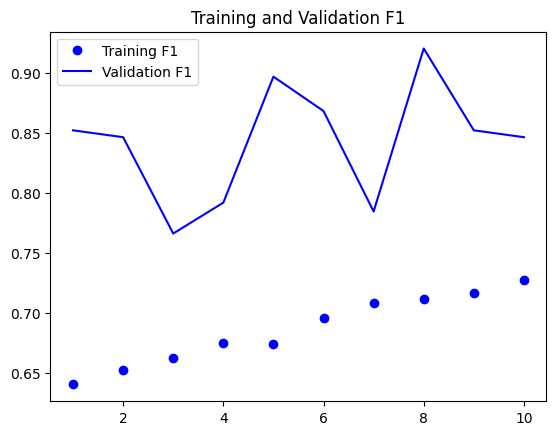

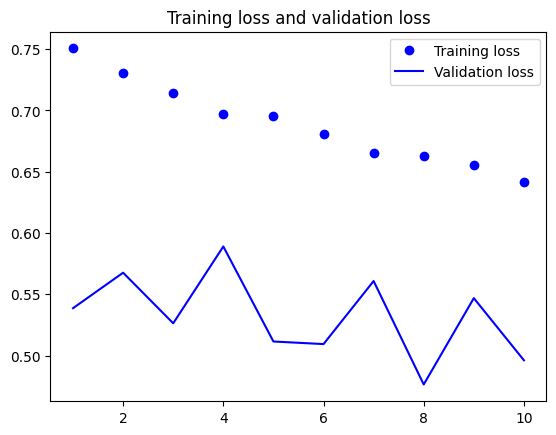

In [15]:
import matplotlib.pyplot as plt 

f1 = history.history['get_f1'] 
val_f1 = history.history['val_get_f1'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(f1) + 1) 

plt.plot(epochs, f1, 'bo', label='Training F1') 
plt.plot(epochs, val_f1, 'b', label='Validation F1') 
plt.title('Training and Validation F1') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training loss and validation loss') 
plt.legend() 

plt.show() 

In [16]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1. / 255,
)

test_datagen.fit(X_test)

test_flow = test_datagen.flow(
    X_test,
    batch_size=batch_size,
    shuffle=False,
    
)

c:\Users\bestlab\Squishy-Methane-Analysis\lib\site-packages\keras\preprocessing\image.py:2092: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (5939, 240, 320, 2) (2 channels).
  warnings.warn(
c:\Users\bestlab\Squishy-Methane-Analysis\lib\site-packages\keras\preprocessing\image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (5939, 240, 320, 2) (2 channels).
  warnings.warn(


In [17]:
predictions = model.predict(test_flow)

186/186 [==============================] - 23s 123ms/step


In [18]:
processed_preds = (predictions >= 0.5).flatten().astype(int)

In [19]:
test_acc = np.sum(processed_preds == y_test) / len(y_test)
print(f'Test Accuracy is {test_acc} after training for {num_epochs} epochs on {len(y_test)} test images')

Test Accuracy is 0.8587304259976427 after training for 10 epochs on 5939 test images


In [20]:
leak_indices = [i for i in range(len(y_test)) if y_test[i] == 1]
nonleak_indices = [i for i in range(len(y_test)) if y_test[i] == 0]
leak_predictions, leak_y_test = processed_preds[leak_indices], y_test[leak_indices]
nonleak_predictions, nonleak_y_test = processed_preds[nonleak_indices], y_test[nonleak_indices]

leak_test_acc = np.sum(leak_predictions == leak_y_test) / len(leak_y_test)
nonleak_test_acc = np.sum(nonleak_predictions == nonleak_y_test) / len(nonleak_y_test)
print(f'Leak Test accuracy is {leak_test_acc} after training for {num_epochs} epochs on {len(leak_y_test)} leak test images')
print(f'Non-Leak Test accuracy is {nonleak_test_acc} after training for {num_epochs} epochs on {len(nonleak_y_test)} non-leak test images')


Leak Test accuracy is 0.9747494217424827 after training for 10 epochs on 5188 leak test images
Non-Leak Test accuracy is 0.05725699067909454 after training for 10 epochs on 751 non-leak test images
